IMPORT DATASETS

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors._kd_tree import KDTree
import time
from data_utils import load_dataset


### Test and Random Seed: run this to have a consistent seed in the code

(5,)


array([[0.],
       [1.],
       [2.],
       [3.],
       [4.]])

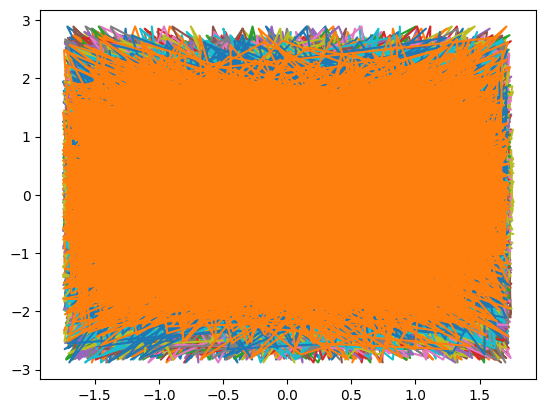

In [76]:
np.random.seed(69)

x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')
plt.plot(x_train, y_train)
np.random.seed(69)
a = np.arange(1000)
# indices = np.array([x for x in range(0, 1000)])
# b = np.arange(1000)
# c = np.random.choice(1000, 2)
# print(np.random.choice(1000, 2))
# print(c[0])

# a = np.array([0,1,2,3])
# a = np.zeros([2, len(x_train[0])])
# print(a)

# print(len(x_train[0]))
ws = np.zeros([5,5])
w = np.array([0,1,2,3,4])
ws[0] =w
print(ws[0].T.shape)
ws[0].reshape(5,1)


### Gradient Descent

- Hyperparameters
    - beta
    - eta
    

The Loss function is the 2 norm of ||y - Xw||, which the gradient is:

$\triangledown L(w) = 2X^T(Xw-y)$

Linear Regression Algorithm modified from Assignment 1

In [71]:
def linear_regression(x_train, y_train, x_test):
    # add a dummy one feature to each x_train and  point
    # Making X matrices
    ### ALREADY DONE 
    # x_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
    # x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])
    # print(len(x_train)): Number of datapoints in D plus the dummy feature of all ones (D+1)
    # print(len(x_train[0])): The number of features (N)

    # Economy SVD
    U, sigma, V_t = scipy.linalg.svd(x_train, full_matrices=False, compute_uv=True)
    w = V_t.T.dot(U.T.dot(y_train) / np.reshape(sigma, (-1,1))) # -1 to let the program reshape by itself
    return x_train.dot(w) # the weighted prediction of test data

def lin_reg_loss(x, y, w):
    return np.mean(np.square(y - x.dot(w)))

    
def linear_regression_gradient(x, y, w):
    return x.T.dot(x.dot(w) - y) / len(x)

# Full-Batch on pumadyn dataset

ideal loss: 0.7216104721384755
eta = 0.001 converged in 0.900578498840332 s in 2986 iterations
eta = 0.01 converged in 0.10550713539123535 s in 297 iterations
eta = 0.1 converged in 0.00999593734741211 s in 28 iterations
eta = 1 converged in 0.001001119613647461 s in 1 iterations


C:\Users\Brian\AppData\Local\Temp\ipykernel_23036\693698284.py:16: RuntimeWarning: overflow encountered in square
  return np.mean(np.square(y - x.dot(w)))
C:\Users\Brian\AppData\Local\Temp\ipykernel_23036\4242853912.py:45: RuntimeWarning: invalid value encountered in subtract
  w = w - eta * g


best eta: 0.01  with test RMSE: 0.8706531086227398


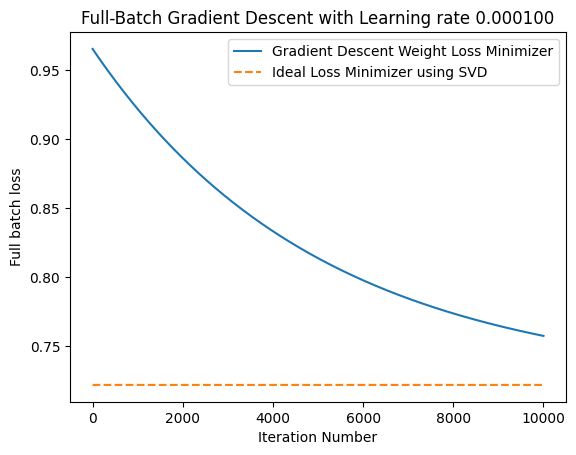

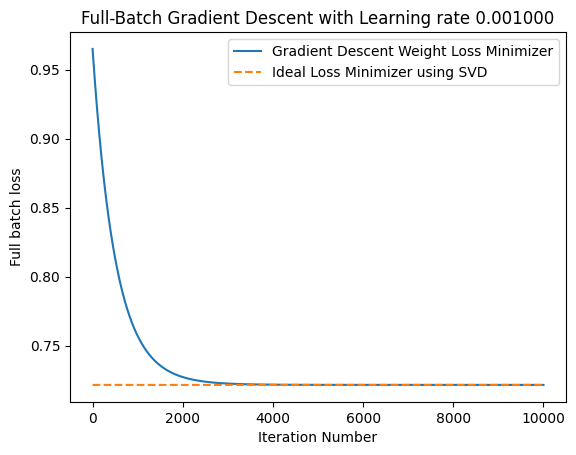

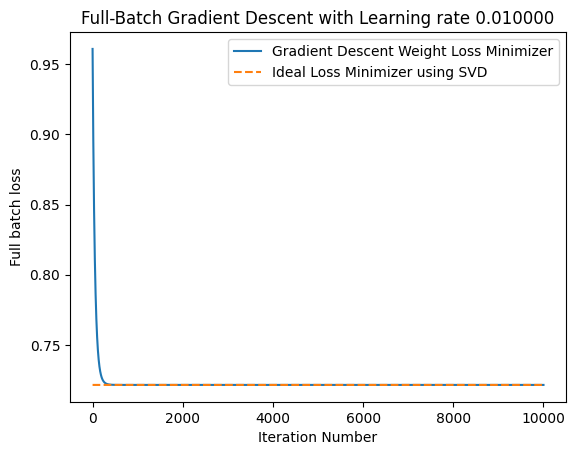

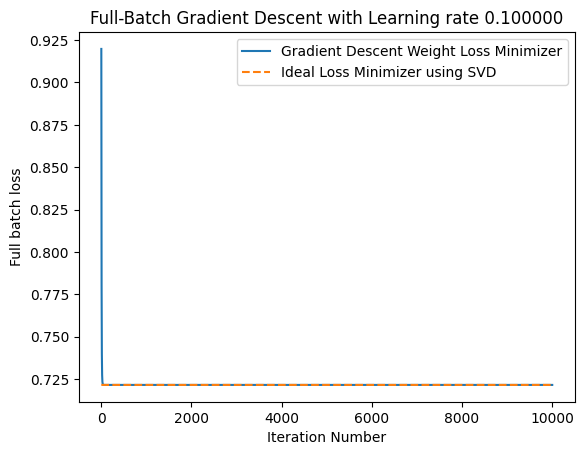

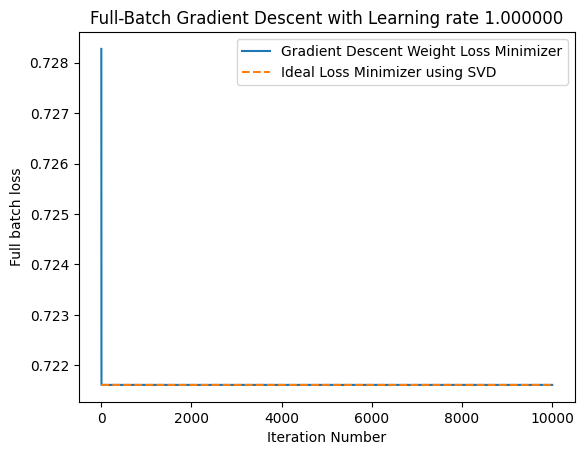

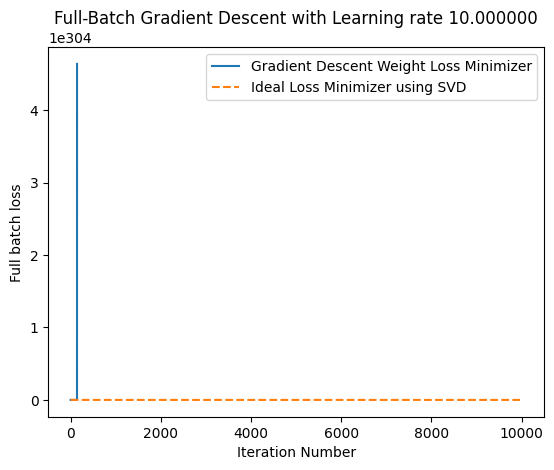

In [35]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')

x_train = np.vstack([x_train, x_valid])
y_train = np.vstack([y_train, y_valid])

# take the first 1000 points: add in the ones vector x_0
x_train = x_train[0:1000]
x_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])
y_train = y_train[0:1000]
# initialize the weight vector w = 0
w = np.zeros([len(x_train[0]), 1])

# choose hyperparameters: test on the dataset
# k = 1
# eta = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 100]
best_eta = None
best_eta_RMSE = float('inf')
best_w = np.zeros([len(x_train[0]), 1]) # final weights corresponding to the best eta

stop = 10000
w = np.zeros([len(x_train[0]), 1])

# plotting 
loss = []
iterations = [x for x in range(1, stop+1)]

# The actual ideal model, using Linear regression algorithm from Assignment 1
y_prediction = linear_regression(x_train, y_train, x_test)
ideal_loss = np.mean(np.square(y_train - y_prediction))
print('ideal loss:',ideal_loss)
ideal_loss_plot = []
for i in range(len(iterations)):
    ideal_loss_plot.append(ideal_loss)


for j, eta in enumerate([0.0001, 0.001, 0.01, 0.1, 1, 10]):
    loss = [] # clear loss array between etas
    w = np.zeros([len(x_train[0]), 1])
    now = time.time()
    converged = False
    for k in range(stop):
        # gradient descent
        g = linear_regression_gradient(x_train, y_train, w)
        w = w - eta * g
        # loss for this iteration is the average of the l2 loss function
        l = lin_reg_loss(x_train, y_train, w)
        loss.append(l)
        # check for convergence by comparing to the optimal loss
        if abs(ideal_loss - l) < 0.001 and converged == False:
            converged = True
            converge_time = time.time() - now
            print(f'eta = {eta} converged in {converge_time} s in {k} iterations')
    # choose eta using the final weights
    if np.sqrt(np.mean(np.square(y_train - x_train.dot(w)))) < best_eta_RMSE:
        best_eta_RMSE = np.sqrt(np.mean(np.square(y_train - x_train.dot(w))))
        best_eta = eta
        best_w = w
    plt.figure()
    plt.plot(iterations, loss)
    plt.plot(iterations, ideal_loss_plot, '--')
    plt.xlabel('Iteration Number')
    plt.ylabel('Full batch loss')
    plt.legend(['Gradient Descent Weight Loss Minimizer', 'Ideal Loss Minimizer using SVD'])
    plt.title(f'Full-Batch Gradient Descent with Learning rate %f' % eta)

test_RMSE = np.sqrt(np.mean(np.square(y_test - x_test.dot(best_w))))
print('best eta:', best_eta, ' with test RMSE:', test_RMSE)

# Stochastic Gradient Descent with Minibatch size 1

C:\Users\Brian\AppData\Local\Temp\ipykernel_13428\693698284.py:16: RuntimeWarning: overflow encountered in square
  return np.mean(np.square(y - x.dot(w)))
C:\Users\Brian\AppData\Local\Temp\ipykernel_13428\1516068330.py:66: RuntimeWarning: overflow encountered in square
  if np.sqrt(np.mean(np.square(y_train - x_train.dot(w)))) < best_eta_RMSE:


best eta: 0.001  with test RMSE: 0.8827435083990027


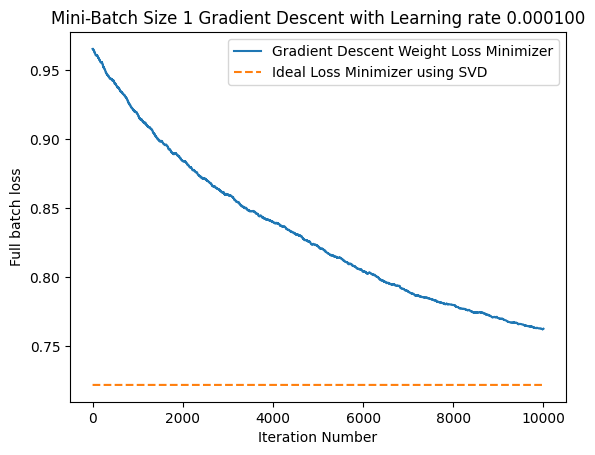

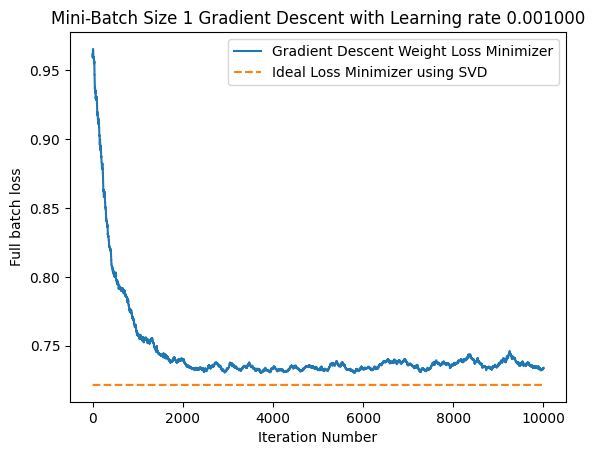

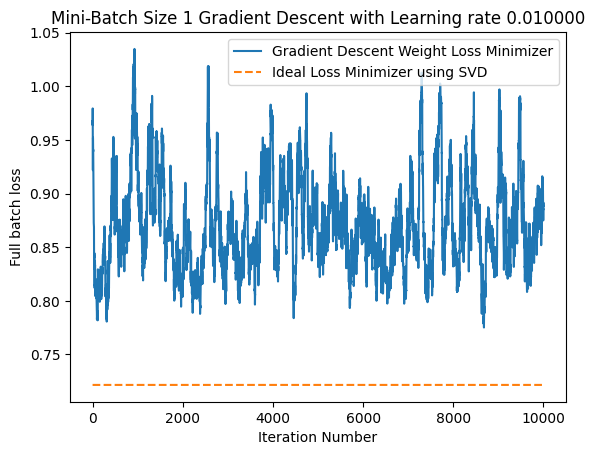

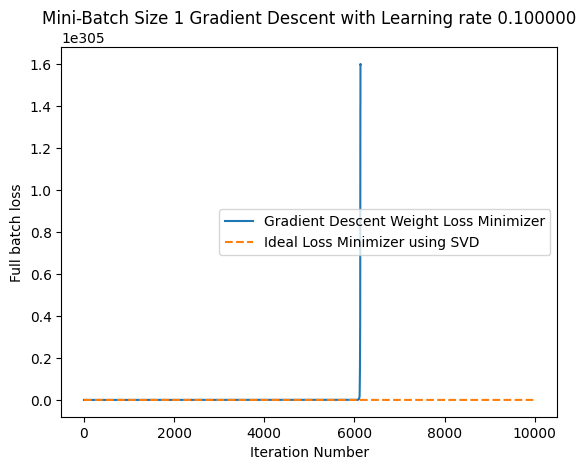

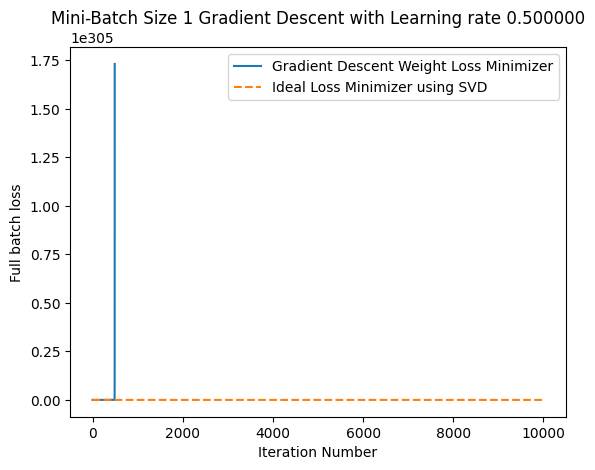

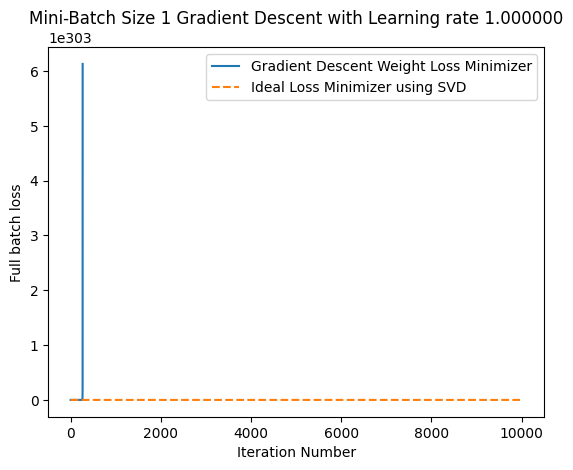

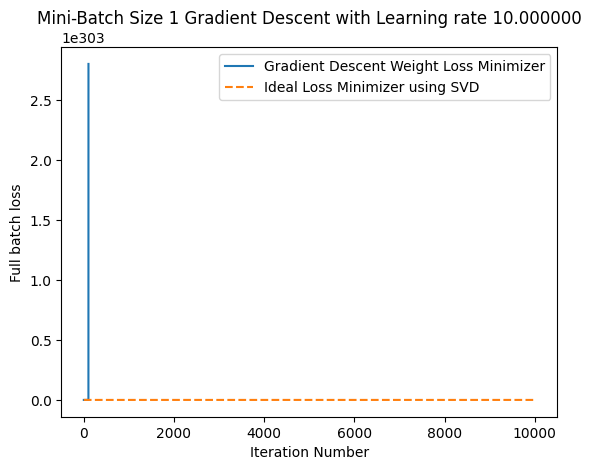

In [73]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')

x_train = np.vstack([x_train, x_valid])
y_train = np.vstack([y_train, y_valid])

# take the first 1000 points: add in the ones vector x_0
x_train = x_train[0:1000]
x_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])
y_train = y_train[0:1000]
# initialize the weight vector w = 0
w = np.zeros([len(x_train[0]), 1])

# choose hyperparameters: test on the dataset
# k = 1
# eta = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 100]
best_eta = None
best_eta_RMSE = float('inf')
best_w = np.zeros([len(x_train[0]), 1]) # final weights corresponding to the best eta

stop = 10000
w = np.zeros([len(x_train[0]), 1])

# plotting 
loss = []
iterations = [x for x in range(1, stop+1)]

# The actual ideal model, using Linear regression algorithm from Assignment 1
y_prediction = linear_regression(x_train, y_train, x_test)
ideal_loss = np.mean(np.square(y_train - y_prediction))
ideal_loss_plot = []
for i in range(len(iterations)):
    ideal_loss_plot.append(ideal_loss)

### Stochastic minibatch
batch_size = 1
np.random.seed(69)

for eta in [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]:
    loss = [] # clear loss array between etas
    w = np.zeros([len(x_train[0]), 1])
    now = time.time()
    converged = False
    for k in range(stop):
        # gradient descent with minibatch
        selections = np.random.choice(1000, batch_size)
        # x and y are slices of x_train and y_train randomly selected
        x = np.zeros([batch_size, len(x_train[0])])
        y = np.zeros([batch_size, len(y_train[0])])
        for i, s in enumerate(selections):
            x[i] = x_train[s]
            y[i] = y_train[s]
        g = linear_regression_gradient(x, y, w)
        w = w - eta * g
        # loss for this iteration is the average of the l2 loss function
        l = lin_reg_loss(x_train, y_train, w)
        loss.append(l)

        # check for convergence by comparing to the optimal loss
        if abs(ideal_loss - l) < 0.001 and converged == False:
            converged = True
            converge_time = time.time() - now
            print(f'eta = {eta} converged in {converge_time} s in {k} iterations')

    # choose eta using the final weights
    if np.sqrt(np.mean(np.square(y_train - x_train.dot(w)))) < best_eta_RMSE:
        best_eta_RMSE = np.sqrt(np.mean(np.square(y_train - x_train.dot(w))))
        best_eta = eta
        best_w = w
    plt.figure()
    plt.plot(iterations, loss)
    plt.plot(iterations, ideal_loss_plot, '--')
    plt.xlabel('Iteration Number')
    plt.ylabel('Full batch loss')
    plt.legend(['Gradient Descent Weight Loss Minimizer', 'Ideal Loss Minimizer using SVD'])
    plt.title(f'Mini-Batch Size 1 Gradient Descent with Learning rate %f' % eta)

test_RMSE = np.sqrt(np.mean(np.square(y_test - x_test.dot(best_w))))
print('best eta:', best_eta, ' with test RMSE:', test_RMSE)

# Mini Batch SGD with Batch size 10

eta = 0.001 converged in 1.0405170917510986 s in 5060 iterations


C:\Users\Brian\AppData\Local\Temp\ipykernel_13428\693698284.py:16: RuntimeWarning: overflow encountered in square
  return np.mean(np.square(y - x.dot(w)))


best eta: 0.001  with test RMSE: 0.871906931812021


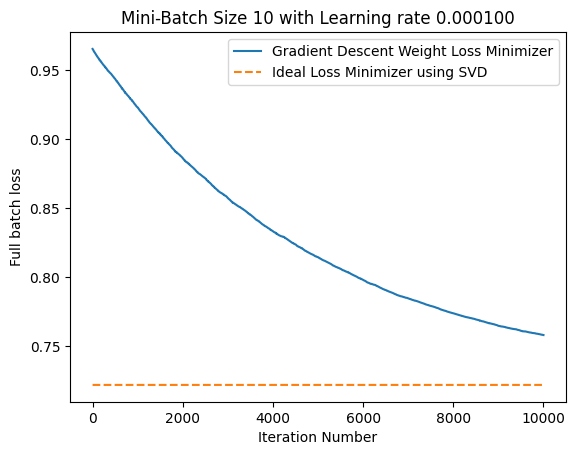

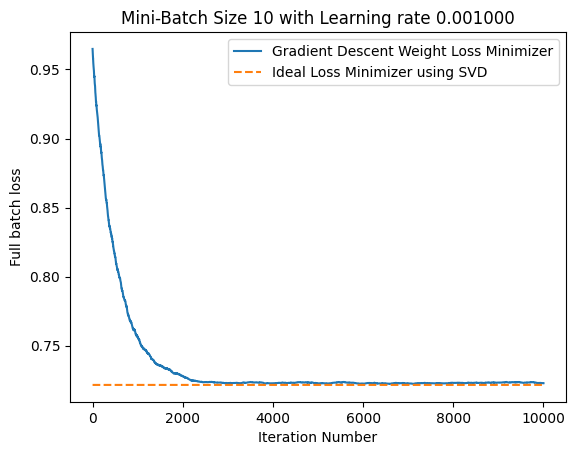

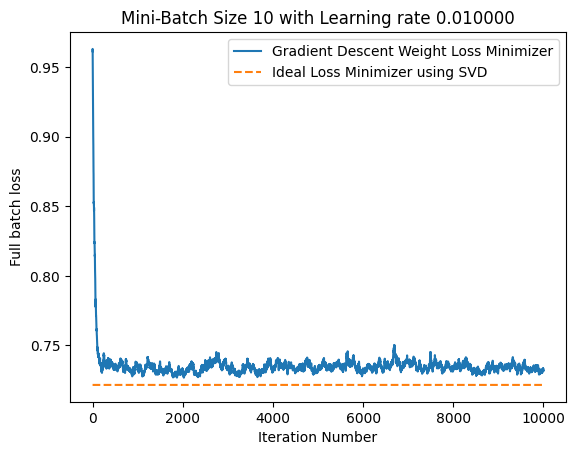

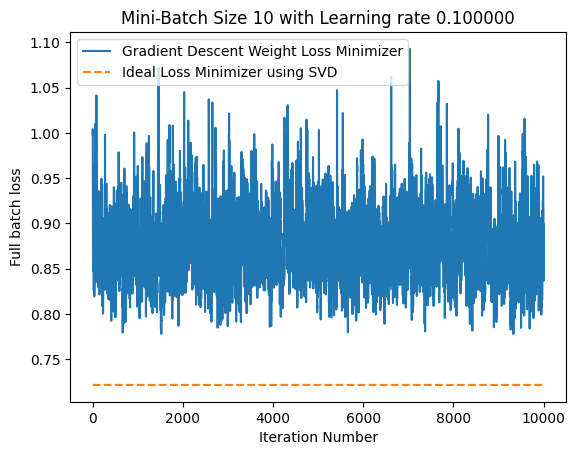

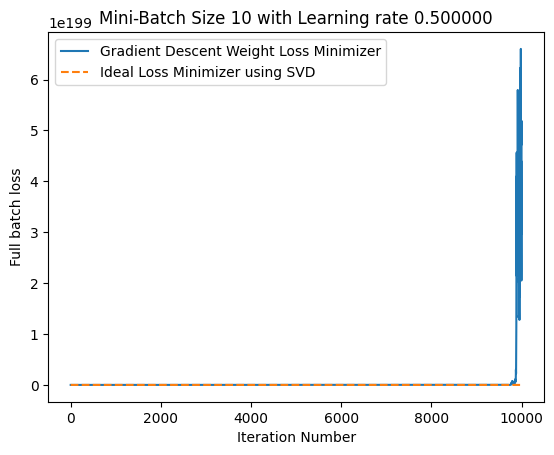

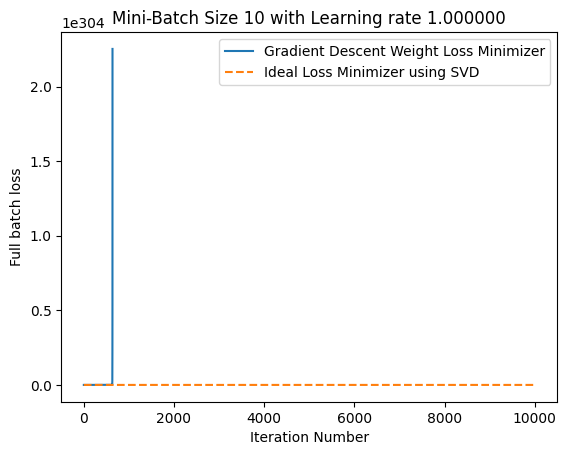

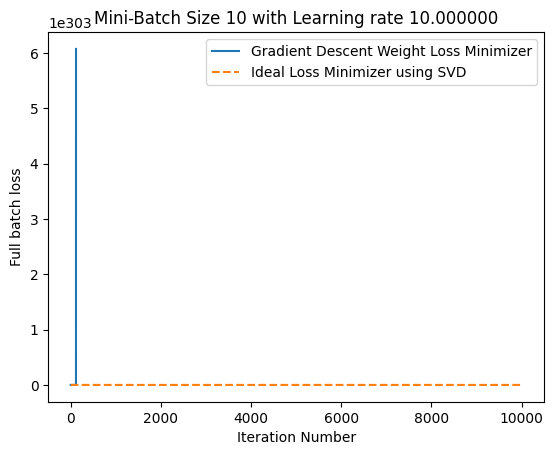

In [74]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')

x_train = np.vstack([x_train, x_valid])
y_train = np.vstack([y_train, y_valid])

# take the first 1000 points: add in the ones vector x_0
x_train = x_train[0:1000]
x_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])
y_train = y_train[0:1000]
# initialize the weight vector w = 0
w = np.zeros([len(x_train[0]), 1])

# choose hyperparameters: test on the dataset
# k = 1
# eta = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 100]
best_eta = None
best_eta_RMSE = float('inf')
best_w = np.zeros([len(x_train[0]), 1]) # final weights corresponding to the best eta

stop = 10000
w = np.zeros([len(x_train[0]), 1])

# plotting 
loss = []
iterations = [x for x in range(1, stop+1)]

# The actual ideal model, using Linear regression algorithm from Assignment 1
y_prediction = linear_regression(x_train, y_train, x_test)
ideal_loss = np.mean(np.square(y_train - y_prediction))
ideal_loss_plot = []
for i in range(len(iterations)):
    ideal_loss_plot.append(ideal_loss)

### Stochastic minibatch
batch_size = 10
np.random.seed(69)

for eta in [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]:
    loss = [] # clear loss array between etas
    w = np.zeros([len(x_train[0]), 1])
    now = time.time()
    converged = False
    for k in range(stop):
        # gradient descent with minibatch
        selections = np.random.choice(1000, batch_size)
        # x and y are slices of x_train and y_train randomly selected
        x = np.zeros([batch_size, len(x_train[0])])
        y = np.zeros([batch_size, len(y_train[0])])
        for i, s in enumerate(selections):
            x[i] = x_train[s]
            y[i] = y_train[s]
        g = linear_regression_gradient(x, y, w)
        w = w - eta * g
        # loss for this iteration is the average of the l2 loss function
        l = lin_reg_loss(x_train, y_train, w)
        loss.append(l)

        # check for convergence by comparing to the optimal loss
        if abs(ideal_loss - l) < 0.001 and converged == False:
            converged = True
            converge_time = time.time() - now
            print(f'eta = {eta} converged in {converge_time} s in {k} iterations')

    # choose eta using the final weights
    if np.sqrt(np.mean(np.square(y_train - x_train.dot(w)))) < best_eta_RMSE:
        best_eta_RMSE = np.sqrt(np.mean(np.square(y_train - x_train.dot(w))))
        best_eta = eta
        best_w = w
    plt.figure()
    plt.plot(iterations, loss)
    plt.plot(iterations, ideal_loss_plot, '--')
    plt.xlabel('Iteration Number')
    plt.ylabel('Full batch loss')
    plt.legend(['Gradient Descent Weight Loss Minimizer', 'Ideal Loss Minimizer using SVD'])
    plt.title(f'Mini-Batch Size 10 with Learning rate %f' % eta)

test_RMSE = np.sqrt(np.mean(np.square(y_test - x_test.dot(best_w))))
print('best eta:', best_eta, ' with test RMSE:', test_RMSE)

# Stochastic Minibatch with Momentum: batch size = 1

C:\Users\Brian\AppData\Local\Temp\ipykernel_13428\693698284.py:16: RuntimeWarning: overflow encountered in square
  return np.mean(np.square(y - x.dot(w)))
C:\Users\Brian\AppData\Local\Temp\ipykernel_13428\666077454.py:70: RuntimeWarning: overflow encountered in square
  if np.sqrt(np.mean(np.square(y_train - x_train.dot(w)))) < best_eta_RMSE:
C:\Users\Brian\AppData\Local\Temp\ipykernel_13428\666077454.py:57: RuntimeWarning: invalid value encountered in add
  g = beta * g + (1 - beta) * linear_regression_gradient(x, y, w)
C:\Users\Brian\AppData\Local\Temp\ipykernel_13428\666077454.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


best eta: 0.001 best beta: 0.9  with test RMSE: 0.8693005790403441


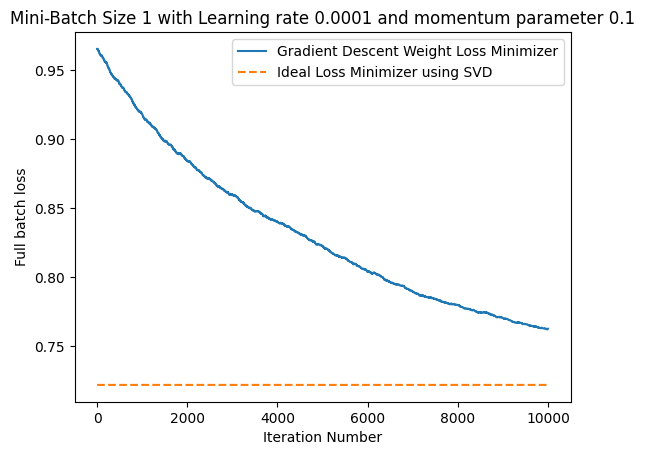

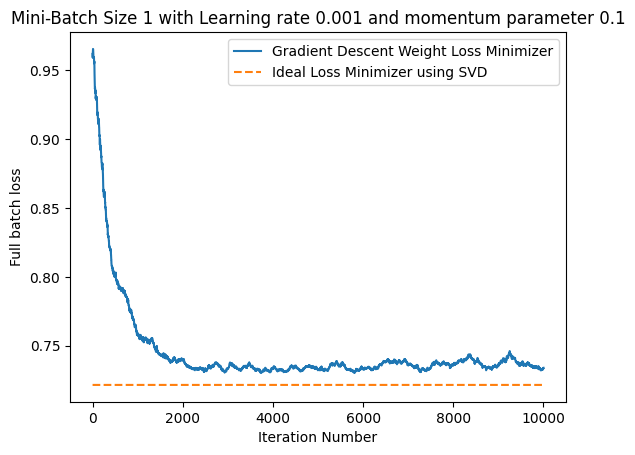

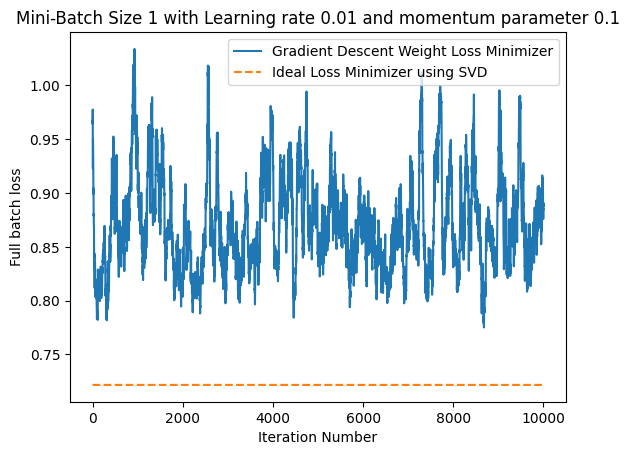

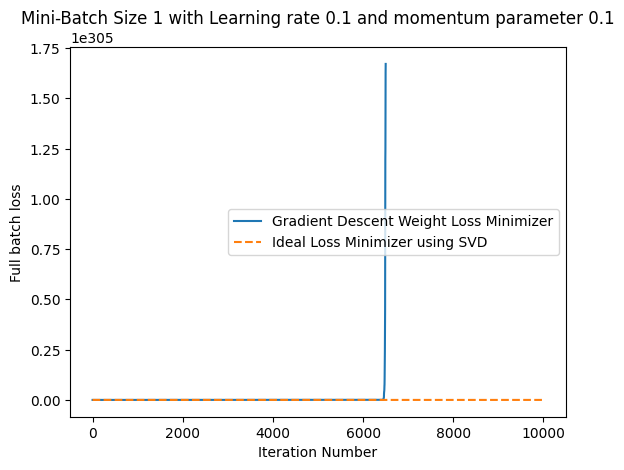

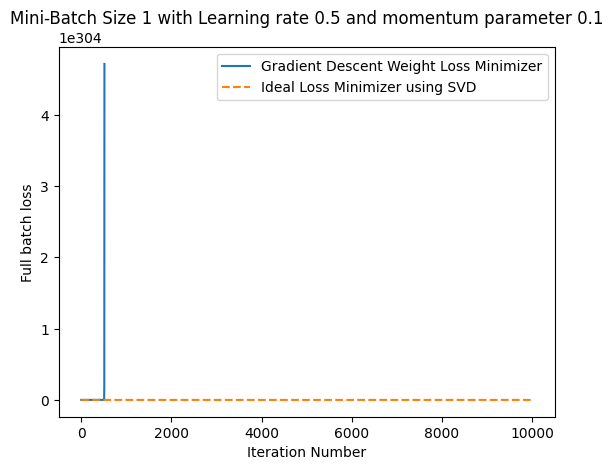

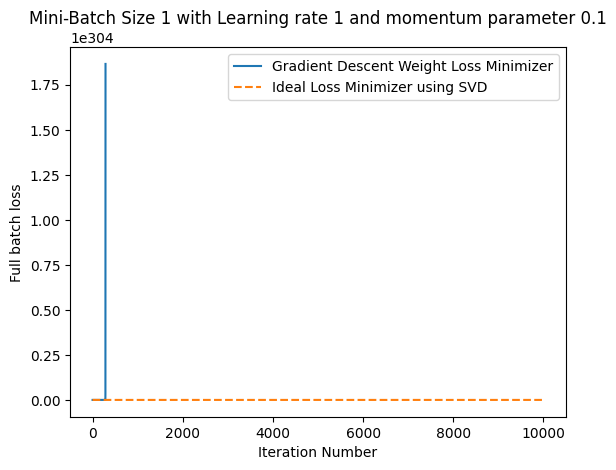

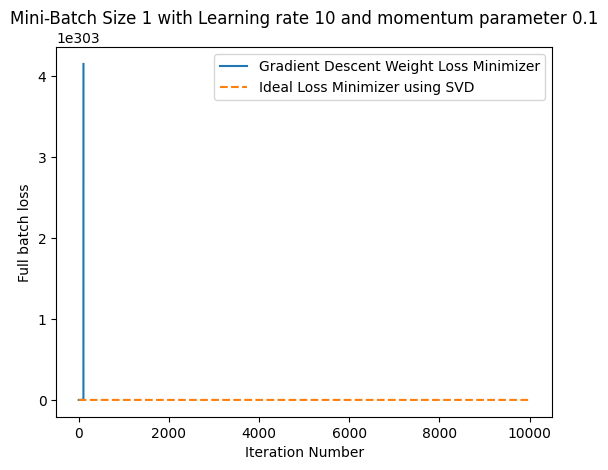

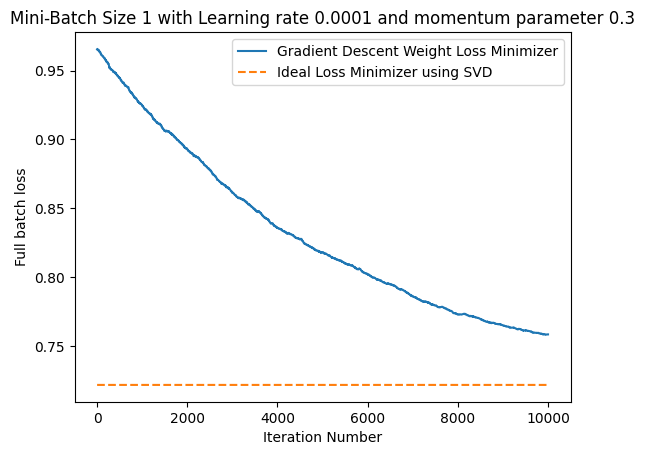

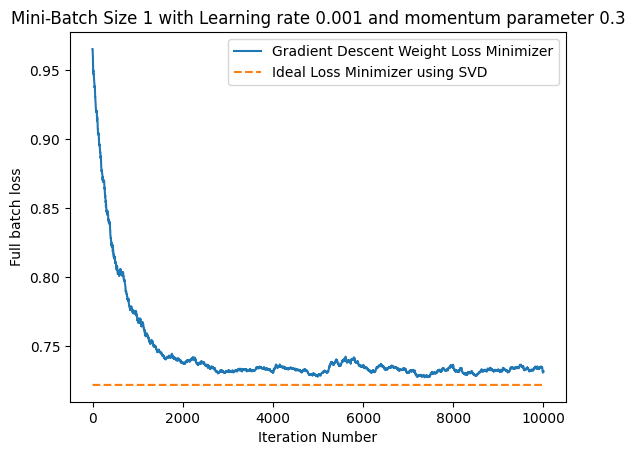

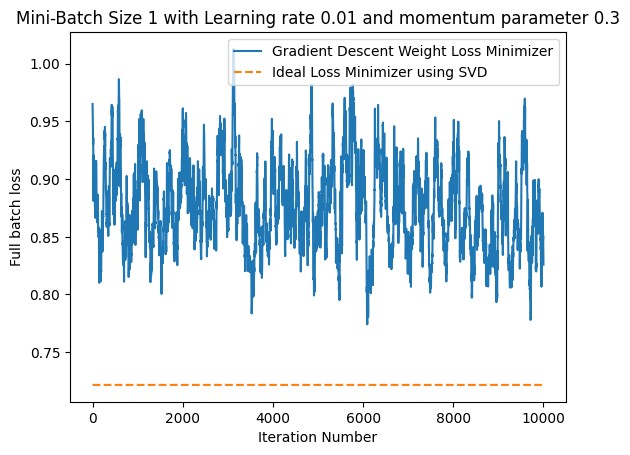

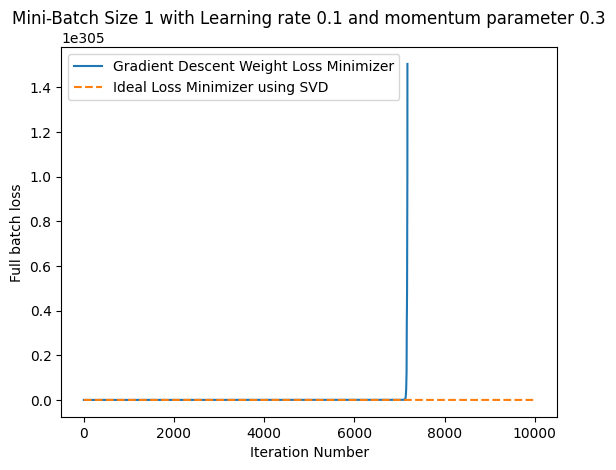

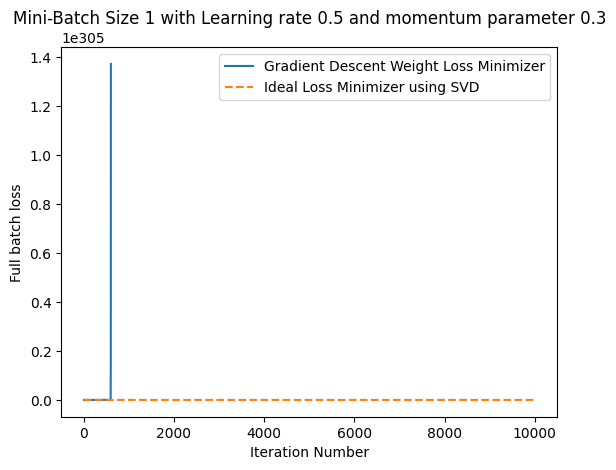

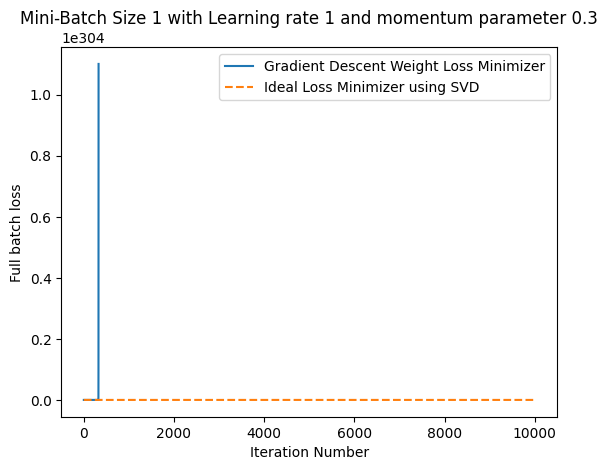

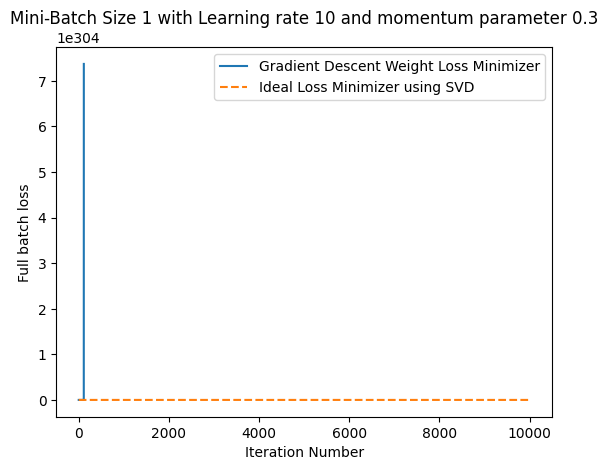

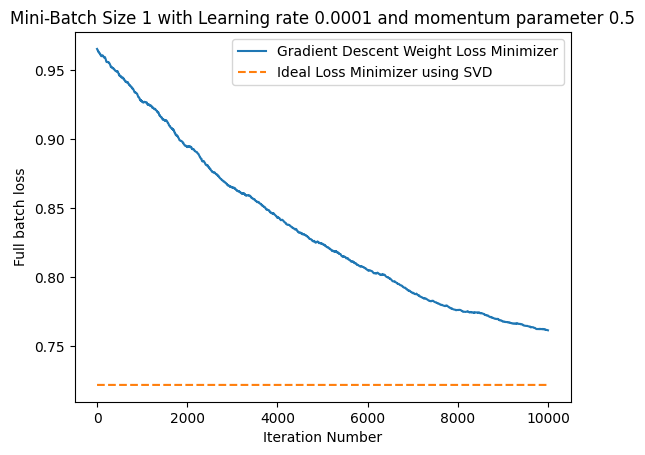

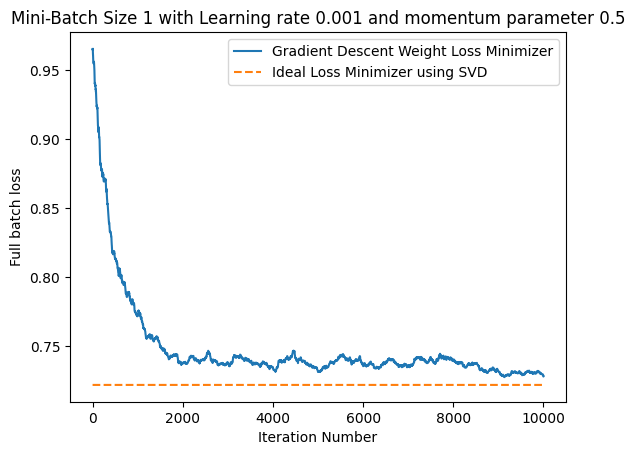

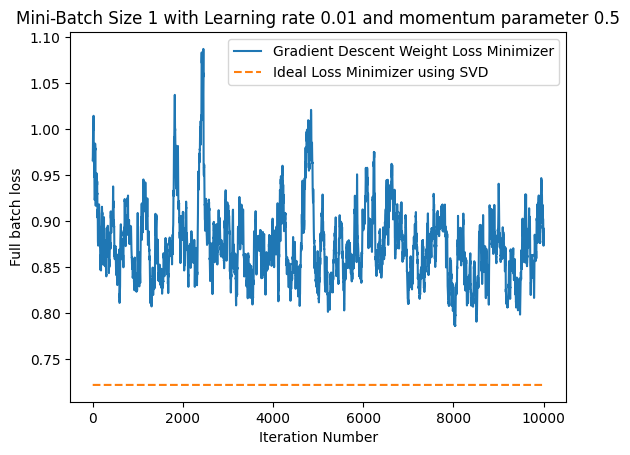

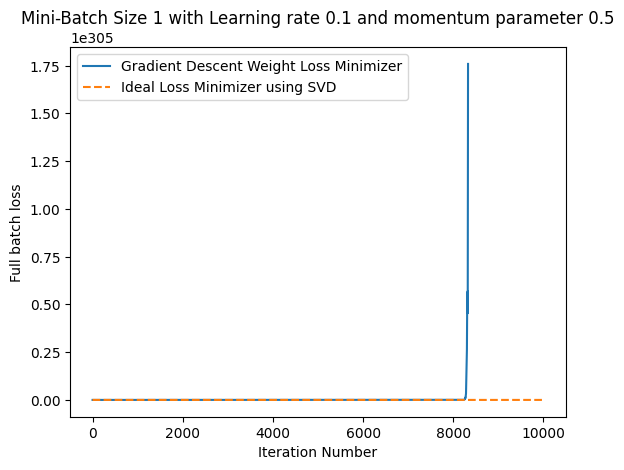

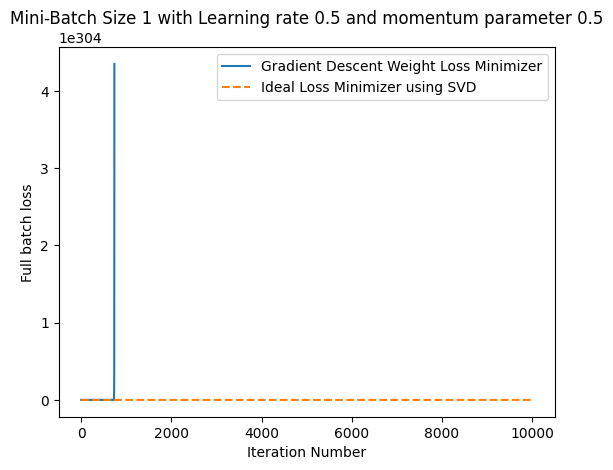

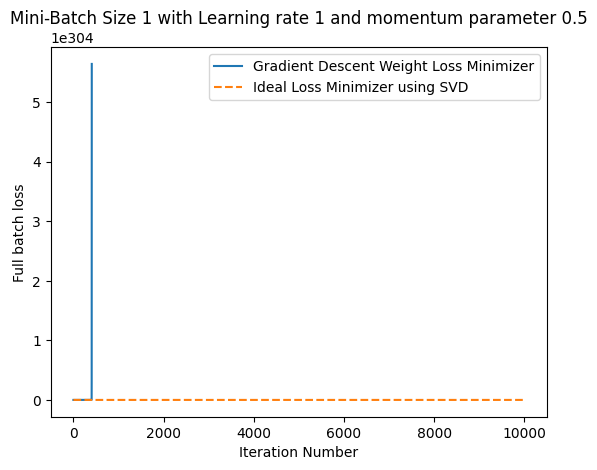

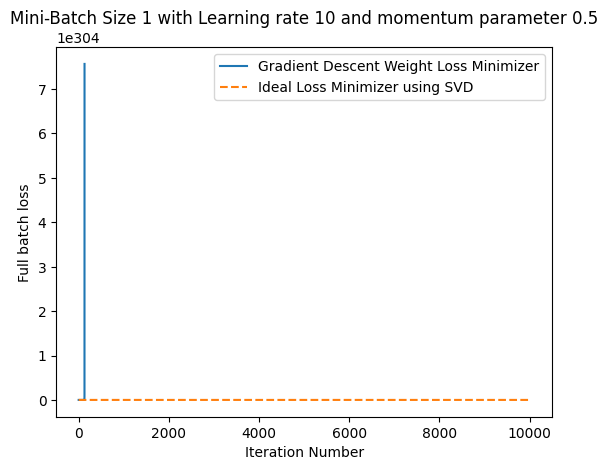

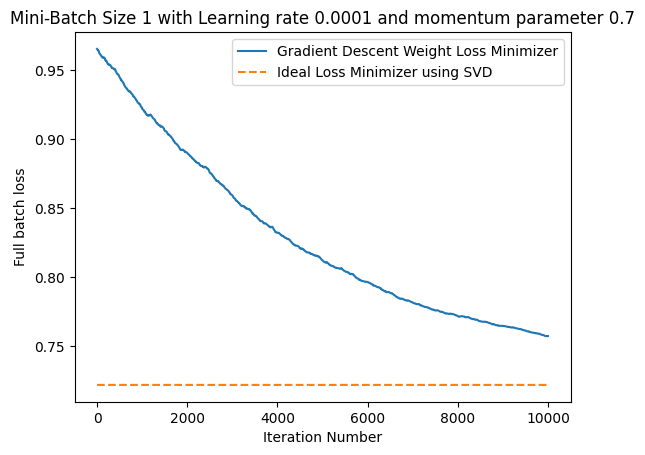

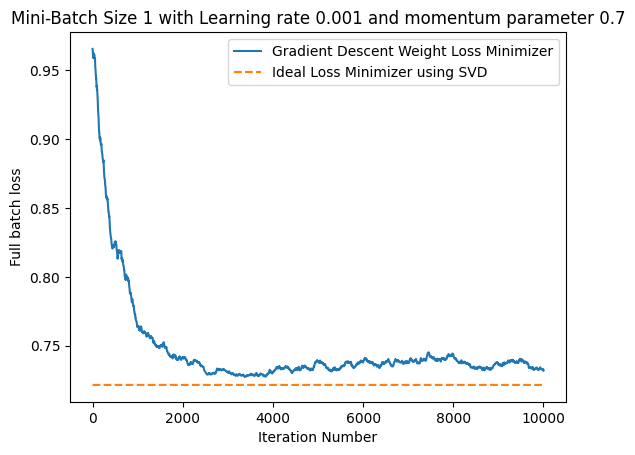

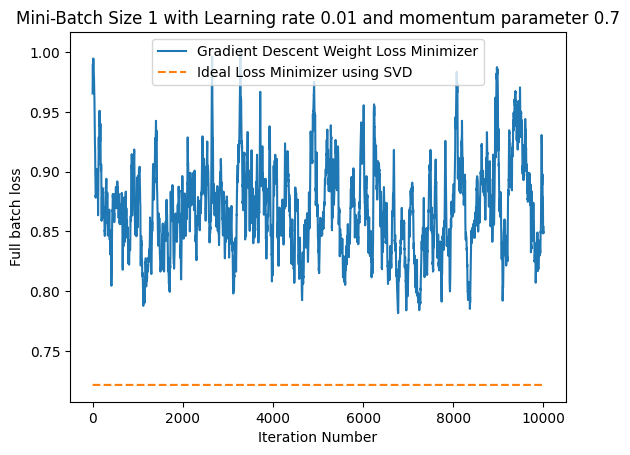

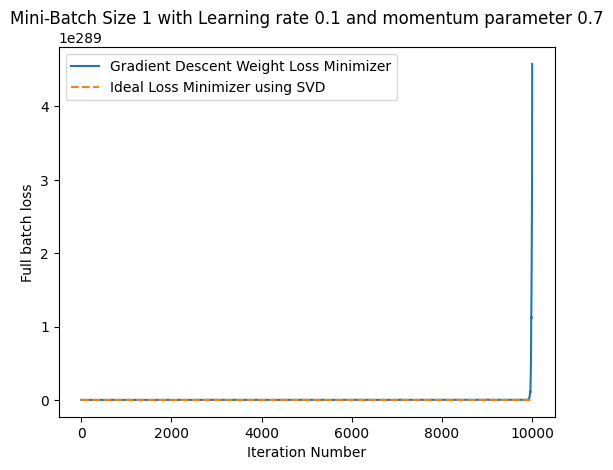

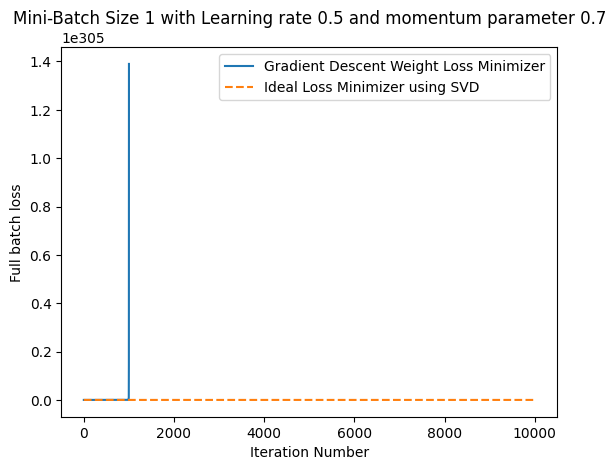

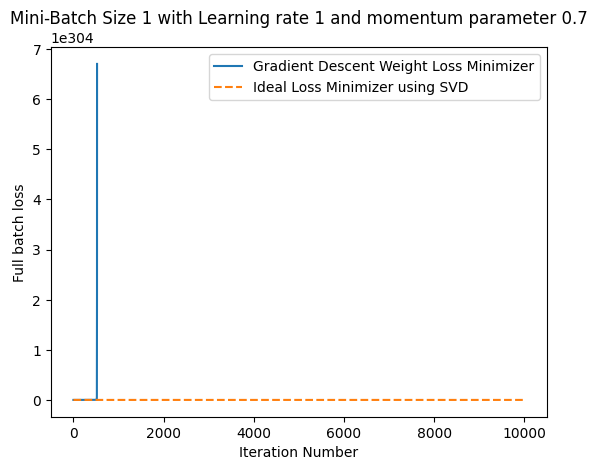

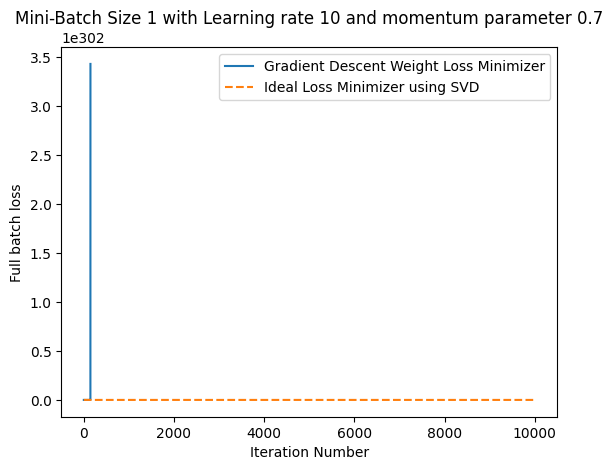

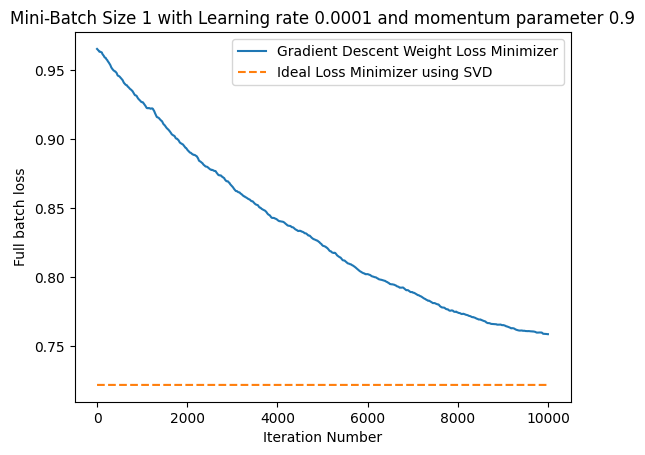

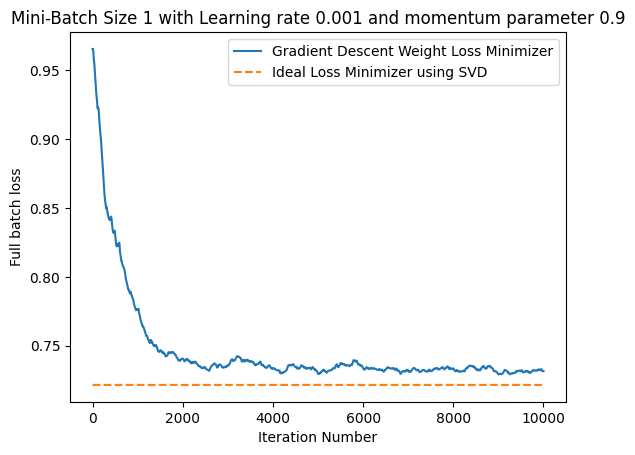

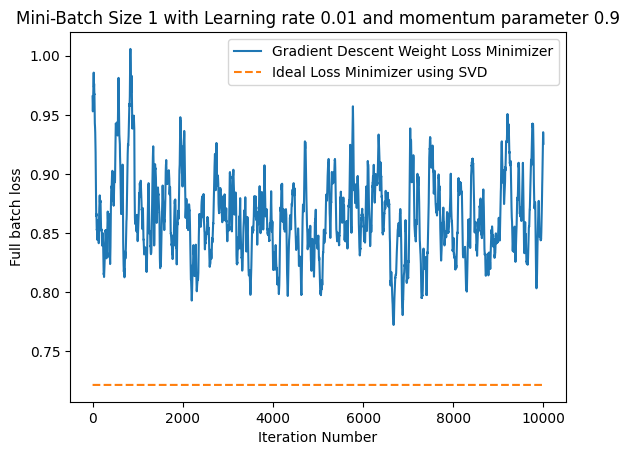

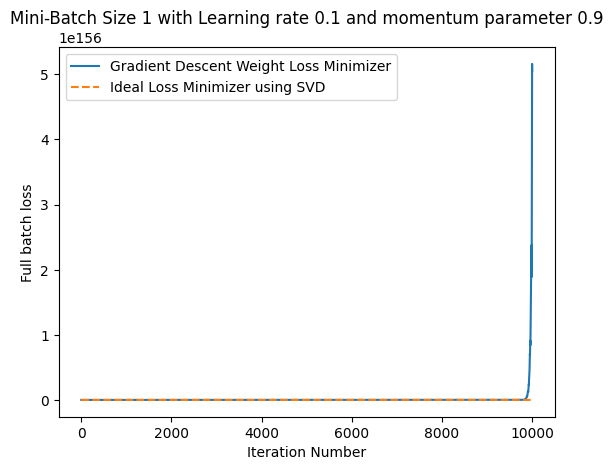

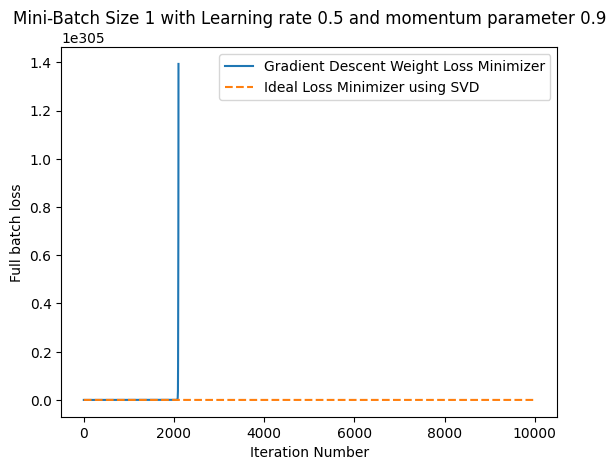

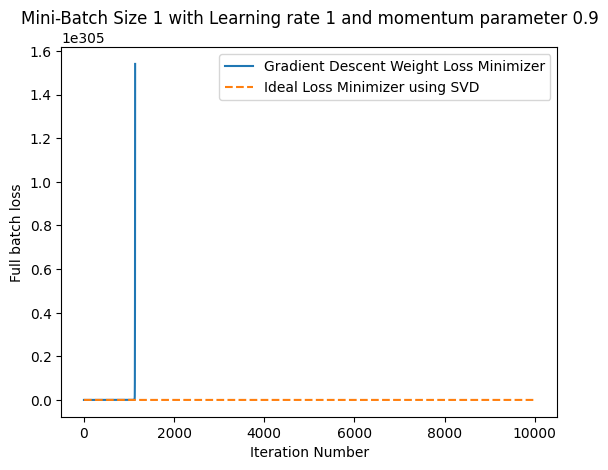

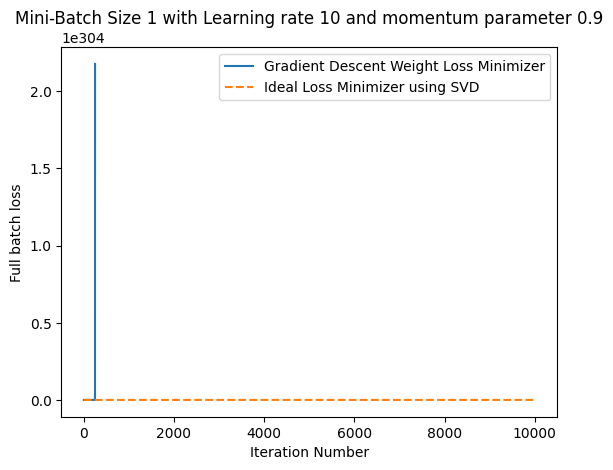

In [75]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('pumadyn32nm')

x_train = np.vstack([x_train, x_valid])
y_train = np.vstack([y_train, y_valid])

# take the first 1000 points: add in the ones vector x_0
x_train = x_train[0:1000]
x_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])
y_train = y_train[0:1000]
# initialize the weight vector w = 0
w = np.zeros([len(x_train[0]), 1])

# choose hyperparameters: test on the dataset
# k = 1
# eta = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 100]
best_eta = None
best_beta = None
best_eta_RMSE = float('inf')
best_w = np.zeros([len(x_train[0]), 1]) # final weights corresponding to the best eta


stop = 10000
w = np.zeros([len(x_train[0]), 1])

# plotting 
loss = []
iterations = [x for x in range(1, stop+1)]

# The actual ideal model, using Linear regression algorithm from Assignment 1
y_prediction = linear_regression(x_train, y_train, x_test)
ideal_loss = np.mean(np.square(y_train - y_prediction))
ideal_loss_plot = []
for i in range(len(iterations)):
    ideal_loss_plot.append(ideal_loss)

### Stochastic minibatch
batch_size = 1
np.random.seed(69)
beta = 0.5
for beta in [0.1, 0.3, 0.5, 0.7, 0.9]:
    for eta in [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]:
        loss = [] # clear loss array between etas
        w = np.zeros([len(x_train[0]), 1])
        g = np.zeros([len(x_train[0]), 1])
        now = time.time()
        converged = False
        for k in range(stop):
            # gradient descent with minibatch
            selections = np.random.choice(1000, batch_size)
            # x and y are slices of x_train and y_train randomly selected
            x = np.zeros([batch_size, len(x_train[0])])
            y = np.zeros([batch_size, len(y_train[0])])
            for i, s in enumerate(selections):
                x[i] = x_train[s]
                y[i] = y_train[s]
            g = beta * g + (1 - beta) * linear_regression_gradient(x, y, w)
            w = w - eta * g
            # loss for this iteration is the average of the l2 loss function
            l = lin_reg_loss(x_train, y_train, w)
            loss.append(l)

        # check for convergence by comparing to the optimal loss
        if abs(ideal_loss - l) < 0.001 and converged == False:
            converged = True
            converge_time = time.time() - now
            print(f'eta = {eta} converged in {converge_time} s in {k} iterations')

        # choose eta using the final weights
        if np.sqrt(np.mean(np.square(y_train - x_train.dot(w)))) < best_eta_RMSE:
            best_eta_RMSE = np.sqrt(np.mean(np.square(y_train - x_train.dot(w))))
            best_eta = eta
            best_beta = beta
            best_w = w
        plt.figure()
        plt.plot(iterations, loss)
        plt.plot(iterations, ideal_loss_plot, '--')
        plt.xlabel('Iteration Number')
        plt.ylabel('Full batch loss')
        plt.legend(['Gradient Descent Weight Loss Minimizer', 'Ideal Loss Minimizer using SVD'])
        plt.title(f'Mini-Batch Size 1 with Learning rate {eta} and momentum parameter {beta}')

test_RMSE = np.sqrt(np.mean(np.square(y_test - x_test.dot(best_w))))
print('best eta:', best_eta, 'best beta:', beta,  ' with test RMSE:', test_RMSE)

### Gradient Descent to Estimate Sigmoid Parameters

In [4]:
def sigmoid(x, w):
    '''
    returns the sigmoid function of x dot w
    '''
    return scipy.special.expit(x.dot(w))

def sigmoid_LL(x, y, w):
    '''
    NEGATIVE sigmoid log likelihood
    '''
    # f = sigmoid(x, w)
    z = x.dot(w)
    f = scipy.special.expit(z)
    return -np.sum(y * np.log(f) + (1-y)*np.log(1-f))

def sigmoid_gradient(x,y,w):
    # f = sigmoid(x,w)
    # temp = y - f
    z = x.dot(w)
    f = scipy.special.expit(z)
    return -np.sum( (y-f) * x, axis = 0, keepdims=True).T # to maintain the gradient as 1xD+1

Full Batch

best eta: 1e-05  with accuracy: [0.73333333]
negative likelihood on the test set: 7.249827997763486


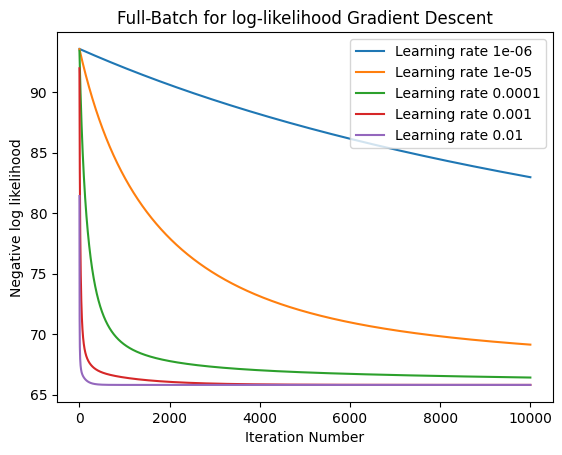

In [7]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')
# use the second feature only
y_train, y_valid, y_test = y_train[:, (1,)], y_valid[:, (1,)], y_test[:, (1,)]
# initialize the x arrays to include the arbitrary ones vector
x_train = np.vstack([x_train, x_valid])
y_train = np.vstack([y_train, y_valid])

x_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])

stop = 10000
# NOTE: changing last idx to eta = 0.01 creates blowup 
all_etas = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
accuracies = np.zeros((len(all_etas), 1))
all_weights = np.zeros([len(x_train[0]), len(all_etas)])
# plotting 
iterations = [x for x in range(1, stop+1)]
likelihood = np.zeros([stop, len(all_etas)]).T

opt_acc = -1
opt_w = None
best_eta = None
for i, eta in enumerate(all_etas):
    # initialize the weight vector w = 0
    w = np.zeros([len(x_train[0]), 1])
    temp_likelihood = []
    best_w = None
    best_likelihood = float('inf')
    for k in range(stop):
        # gradient descent
        g = sigmoid_gradient(x_train, y_train, w)
        w = w - eta * g
        # loss for this iteration is the average of the l2 loss function
        l = sigmoid_LL(x_train, y_train, w)
        temp_likelihood.append(l)
        if l < best_likelihood:
            best_likelihood = l
            best_w = w

    all_weights[i] = best_w.T
    likelihood[i] = temp_likelihood
    accuracies[i] = np.mean((scipy.special.expit(x_test.dot(best_w)) > 0.5) == y_test)
    if accuracies[i] > opt_acc:
        opt_acc = accuracies[i]
        opt_w = best_w
        best_eta = eta



### rows of all_weights and likelihood are the guys we want
#print(all_weights)
#print(all_weights.T)
# best_acc = -1
# best_eta = None
# best_likelihood = None
# best_w = None
for i in range(len(all_etas)):
    plt.plot(iterations, likelihood[i])
    plt.xlabel('Iteration Number')
    plt.ylabel('Negative log likelihood')
    plt.title('Full-Batch for log-likelihood Gradient Descent')

full_likelihood = likelihood[1]
plt.legend([f'Learning rate {all_etas[0]}', f'Learning rate {all_etas[1]}', f'Learning rate {all_etas[2]}', f'Learning rate {all_etas[3]}', f'Learning rate {all_etas[4]}'], loc='upper right')
print('best eta:', best_eta, ' with accuracy:', opt_acc)
print('negative likelihood on the test set:', sigmoid_LL(x_test, y_test, opt_w))
# a right guess is when the sigmoid function is greater than 0.5: test accuracy calculated using weights

# test_f = sigmoid(x_test, w)
# acc = np.mean((test_f > 0.5) == y_test)
# print('accuracy:', acc)
# # log likelihood on the test set (negative)p
# print('negative likelihood:', sigmoid_LL(x_test, y_test, w))

With larger learning rates

best eta: 1e-05  with accuracy: [0.73333333]
negative likelihood on the test set: 7.249827997763486


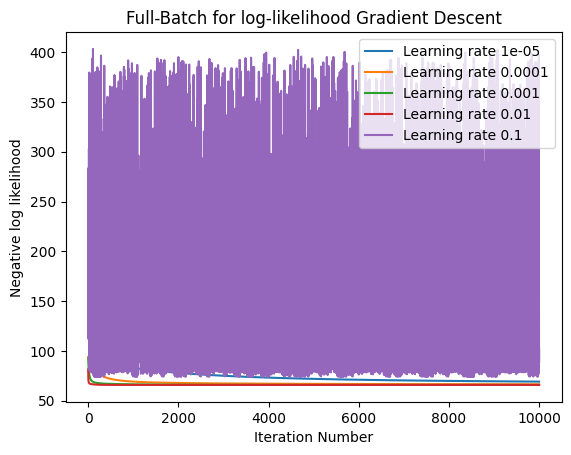

In [69]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')
# use the second feature only
y_train, y_valid, y_test = y_train[:, (1,)], y_valid[:, (1,)], y_test[:, (1,)]
# initialize the x arrays to include the arbitrary ones vector
x_train = np.vstack([x_train, x_valid])
y_train = np.vstack([y_train, y_valid])

x_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])

stop = 10000

all_etas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
accuracies = np.zeros((len(all_etas), 1))
all_weights = np.zeros([len(x_train[0]), len(all_etas)])
# plotting 
iterations = [x for x in range(1, stop+1)]
likelihood = np.zeros([stop, len(all_etas)]).T

opt_acc = -1
opt_w = None
best_eta = None
for i, eta in enumerate(all_etas):
    # initialize the weight vector w = 0
    w = np.zeros([len(x_train[0]), 1])
    temp_likelihood = []
    best_w = None
    best_likelihood = float('inf')
    for k in range(stop):
        # gradient descent
        g = sigmoid_gradient(x_train, y_train, w)
        w = w - eta * g
        # loss for this iteration is the average of the l2 loss function
        l = sigmoid_LL(x_train, y_train, w)
        temp_likelihood.append(l)
        if l < best_likelihood:
            best_likelihood = l
            best_w = w

    all_weights[i] = best_w.T
    likelihood[i] = temp_likelihood
    accuracies[i] = np.mean((scipy.special.expit(x_test.dot(best_w)) > 0.5) == y_test)
    if accuracies[i] > opt_acc:
        opt_acc = accuracies[i]
        opt_w = best_w
        best_eta = eta



### rows of all_weights and likelihood are the guys we want
#print(all_weights)
#print(all_weights.T)
# best_acc = -1
# best_eta = None
# best_likelihood = None
# best_w = None
for i in range(len(all_etas)):
    plt.plot(iterations, likelihood[i])
    plt.xlabel('Iteration Number')
    plt.ylabel('Negative log likelihood')
    plt.title('Full-Batch for log-likelihood Gradient Descent')


plt.legend([f'Learning rate {all_etas[0]}', f'Learning rate {all_etas[1]}', f'Learning rate {all_etas[2]}', f'Learning rate {all_etas[3]}', f'Learning rate {all_etas[4]}'], loc='upper right')
print('best eta:', best_eta, ' with accuracy:', opt_acc)
print('negative likelihood on the test set:', sigmoid_LL(x_test, y_test, opt_w))
# a right guess is when the sigmoid function is greater than 0.5: test accuracy calculated using weights

# test_f = sigmoid(x_test, w)
# acc = np.mean((test_f > 0.5) == y_test)
# print('accuracy:', acc)
# # log likelihood on the test set (negative)p
# print('negative likelihood:', sigmoid_LL(x_test, y_test, w))

Minibatch, batch size = 1

best eta: 0.001  with accuracy: [0.73333333]
negative likelihood on the test set: 7.3768858787854485


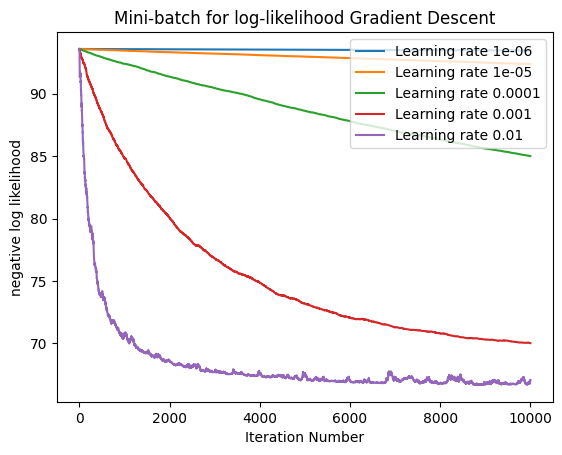

In [6]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')
# use the second feature only
y_train, y_valid, y_test = y_train[:, (1,)], y_valid[:, (1,)], y_test[:, (1,)]
# initialize the x arrays to include the arbitrary ones vector
x_train = np.vstack([x_train, x_valid])
y_train = np.vstack([y_train, y_valid])

x_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])

# ACTUAL IDEAL MODEL OMITTED: we will used a fixed eta and large step size
stop = 10000
# NOTE: changing last idx to eta = 0.01 creates blowup 
all_etas = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
accuracies = np.zeros((len(all_etas), 1))
all_weights = np.zeros([len(x_train[0]), len(all_etas)])
# plotting 
iterations = [x for x in range(1, stop+1)]
likelihood = np.zeros([stop, len(all_etas)]).T

opt_acc = -1
opt_w = None
best_eta = None
batch_size = 1
for i, eta in enumerate(all_etas):
    # initialize the weight vector w = 0
    w = np.zeros([len(x_train[0]), 1])
    temp_likelihood = []
    best_w = None
    best_likelihood = float('inf')
    for k in range(stop):
        selection = np.random.choice(len(x_train), batch_size)
        # gradient descent
        g = sigmoid_gradient(x_train[selection], y_train[selection], w)
        w = w - eta * g
        # loss for this iteration is the average of the l2 loss function
        l = sigmoid_LL(x_train, y_train, w)
        temp_likelihood.append(l)
        if l < best_likelihood:
            best_likelihood = l
            best_w = w

    all_weights[i] = best_w.T
    likelihood[i] = temp_likelihood
    accuracies[i] = np.mean((scipy.special.expit(x_test.dot(best_w)) > 0.5) == y_test)
    if accuracies[i] > opt_acc:
        opt_acc = accuracies[i]
        opt_w = best_w
        best_eta = eta



### rows of all_weights and likelihood are the guys we want
#print(all_weights)
#print(all_weights.T)
# best_acc = -1
# best_eta = None
# best_likelihood = None
# best_w = None
for i in range(len(all_etas)):
    plt.plot(iterations, likelihood[i])
    plt.xlabel('Iteration Number')
    plt.ylabel('negative log likelihood')
    plt.title('Mini-batch for log-likelihood Gradient Descent')

mini_likelihood = likelihood[3]

plt.legend([f'Learning rate {all_etas[0]}', f'Learning rate {all_etas[1]}', f'Learning rate {all_etas[2]}', f'Learning rate {all_etas[3]}', f'Learning rate {all_etas[4]}'], loc='upper right')
print('best eta:', best_eta, ' with accuracy:', opt_acc)
print('negative likelihood on the test set:', sigmoid_LL(x_test, y_test, opt_w))
# a right guess is when the sigmoid function is greater than 0.5: test accuracy calculated using weights

# test_f = sigmoid(x_test, w)
# acc = np.mean((test_f > 0.5) == y_test)
# print('accuracy:', acc)
# # log likelihood on the test set (negative)p
# print('negative likelihood:', sigmoid_LL(x_test, y_test, w))

reperform with larger learning rates

best eta: 0.001  with accuracy: [0.73333333]
negative likelihood on the test set: 7.508716269290297


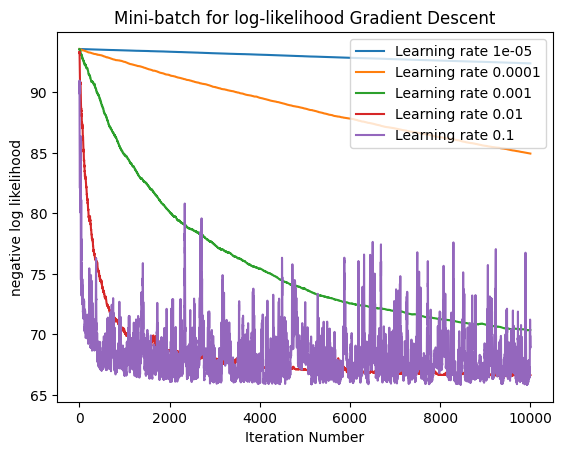

In [64]:
x_train, x_valid, x_test, y_train, y_valid, y_test = load_dataset('iris')
# use the second feature only
y_train, y_valid, y_test = y_train[:, (1,)], y_valid[:, (1,)], y_test[:, (1,)]
# initialize the x arrays to include the arbitrary ones vector
x_train = np.vstack([x_train, x_valid])
y_train = np.vstack([y_train, y_valid])

x_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
x_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])

# ACTUAL IDEAL MODEL OMITTED: we will used a fixed eta and large step size
stop = 10000
# NOTE: changing last idx to eta = 0.01 creates blowup 
all_etas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
accuracies = np.zeros((len(all_etas), 1))
all_weights = np.zeros([len(x_train[0]), len(all_etas)])
# plotting 
iterations = [x for x in range(1, stop+1)]
likelihood = np.zeros([stop, len(all_etas)]).T

opt_acc = -1
opt_w = None
best_eta = None
batch_size = 1
for i, eta in enumerate(all_etas):
    # initialize the weight vector w = 0
    w = np.zeros([len(x_train[0]), 1])
    temp_likelihood = []
    best_w = None
    best_likelihood = float('inf')
    for k in range(stop):
        selection = np.random.choice(len(x_train), batch_size)
        # gradient descent
        g = sigmoid_gradient(x_train[selection], y_train[selection], w)
        w = w - eta * g
        # loss for this iteration is the average of the l2 loss function
        l = sigmoid_LL(x_train, y_train, w)
        temp_likelihood.append(l)
        if l < best_likelihood:
            best_likelihood = l
            best_w = w

    all_weights[i] = best_w.T
    likelihood[i] = temp_likelihood
    accuracies[i] = np.mean((scipy.special.expit(x_test.dot(best_w)) > 0.5) == y_test)
    if accuracies[i] > opt_acc:
        opt_acc = accuracies[i]
        opt_w = best_w
        best_eta = eta



### rows of all_weights and likelihood are the guys we want
#print(all_weights)
#print(all_weights.T)
# best_acc = -1
# best_eta = None
# best_likelihood = None
# best_w = None
for i in range(len(all_etas)):
    plt.plot(iterations, likelihood[i])
    plt.xlabel('Iteration Number')
    plt.ylabel('negative log likelihood')
    plt.title('Mini-batch for log-likelihood Gradient Descent')


plt.legend([f'Learning rate {all_etas[0]}', f'Learning rate {all_etas[1]}', f'Learning rate {all_etas[2]}', f'Learning rate {all_etas[3]}', f'Learning rate {all_etas[4]}'], loc='upper right')
print('best eta:', best_eta, ' with accuracy:', opt_acc)
print('negative likelihood on the test set:', sigmoid_LL(x_test, y_test, opt_w))
# a right guess is when the sigmoid function is greater than 0.5: test accuracy calculated using weights

# test_f = sigmoid(x_test, w)
# acc = np.mean((test_f > 0.5) == y_test)
# print('accuracy:', acc)
# # log likelihood on the test set (negative)p
# print('negative likelihood:', sigmoid_LL(x_test, y_test, w))

Mini-batch vs Full-Batch

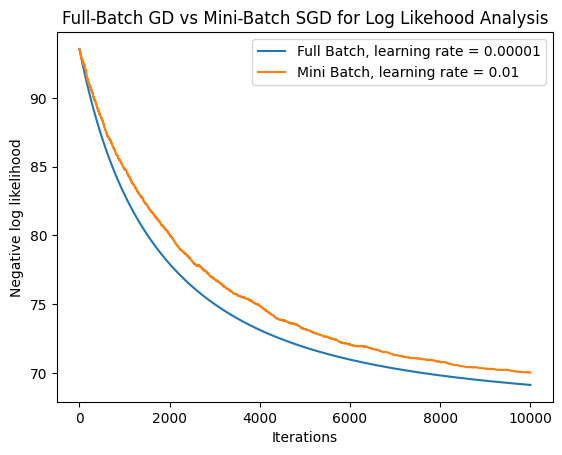

In [10]:
plt.plot(iterations, full_likelihood)
plt.plot(iterations, mini_likelihood)
plt.title('Full-Batch GD vs Mini-Batch SGD for Log Likehood Analysis')
plt.xlabel('Iterations')
plt.ylabel('Negative log likelihood')
plt.legend(['Full Batch, learning rate = 0.00001', 'Mini Batch, learning rate = 0.01'])